<a href="https://colab.research.google.com/github/Zakeerullah/Zaki1/blob/main/Alexnet_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 103MB/s]


Epoch [1/10], Train Loss: 0.4318, Train Accuracy: 90.62%
Epoch [1/10], Validation Loss: 0.2118, Validation Accuracy: 93.38%
Validation loss decreased, saving model...
Epoch [2/10], Train Loss: 0.1434, Train Accuracy: 95.81%
Epoch [2/10], Validation Loss: 0.2631, Validation Accuracy: 94.90%
Epoch [3/10], Train Loss: 0.1643, Train Accuracy: 95.92%
Epoch [3/10], Validation Loss: 0.0330, Validation Accuracy: 99.16%
Validation loss decreased, saving model...
Epoch [4/10], Train Loss: 0.2096, Train Accuracy: 95.89%
Epoch [4/10], Validation Loss: 0.4024, Validation Accuracy: 93.38%
Epoch [5/10], Train Loss: 0.3674, Train Accuracy: 95.89%
Epoch [5/10], Validation Loss: 0.1594, Validation Accuracy: 96.81%
Epoch [6/10], Train Loss: 0.4571, Train Accuracy: 96.34%
Epoch [6/10], Validation Loss: 0.1189, Validation Accuracy: 98.17%
Epoch [7/10], Train Loss: 0.2490, Train Accuracy: 97.27%
Epoch [7/10], Validation Loss: 0.2330, Validation Accuracy: 97.11%
Epoch [8/10], Train Loss: 0.1121, Train Accura

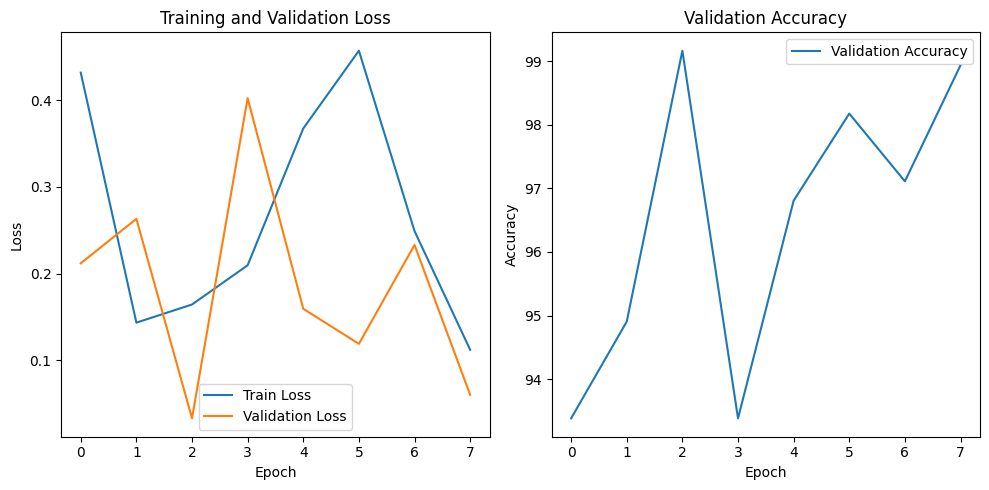

Test Accuracy: 99.17%


RuntimeError: Parent directory /content/drive/MyDrive/Colab Notebooks/Model does not exist.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torchvision.models as models
from sklearn.metrics import classification_report

# Load the data
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.5, contrast=0.5),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_dataset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/Dataset/train', transform=train_transform)
val_dataset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/Dataset/validation', transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/Dataset/test', transform=transform)

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


# Load pretrained AlexNet
model = models.alexnet(pretrained=True)
num_classes = 2  # Real and Fake


# Modify the classifier part of your model
model.classifier = nn.Sequential(
    nn.Linear(9216, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),  # Add dropout layer
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),  # Add another dropout layer
    nn.Linear(4096, num_classes)
)

# Freeze the layers
for param in model.features.parameters():
    param.requires_grad = False

# Unfreeze the classifier layers
for param in model.classifier.parameters():
    param.requires_grad = True


# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Initialize lists to collect loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Initialize EarlyStopping parameters
best_val_loss = float('inf')
patience = 5
no_improvement_count = 0


for epoch in range(10):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    train_losses.append(train_loss / len(train_loader))
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Print epoch progress
    print(f'Epoch [{epoch+1}/10], Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%')

    scheduler.step()

    # Validate the model
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    for val_images, val_labels in val_loader:
        val_outputs = model(val_images)
        val_loss += criterion(val_outputs, val_labels).item()
        _, predicted = torch.max(val_outputs, 1)
        total_val += val_labels.size(0)
        correct_val += (predicted == val_labels).sum().item()
    val_losses.append(val_loss / len(val_loader))
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)

    # Print validation results
    print(f'Epoch [{epoch+1}/10], Validation Loss: {val_loss / len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    # Check if validation loss improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_count = 0
        # Save the model checkpoint if validation loss improved
        torch.save(model.state_dict(), 'model_best.pth')
        print('Validation loss decreased, saving model...')
    else:
        no_improvement_count += 1

    # Early stopping condition
    if no_improvement_count >= patience:
        print("Early stopping triggered. Stopping training.")
        break


# Plot accuracy and loss curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate on test set
model.eval()
correct_test = 0
total_test = 0
all_predicted = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        all_predicted.extend(predicted.tolist())
        all_labels.extend(labels.tolist())

test_accuracy = 100 * correct_test / total_test
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Save the trained model
torch.save(model.state_dict(), 'Alexnet_model.pth')

# Save the trained model's state dictionary
model_save_path = '/content/drive/MyDrive/Colab Notebooks/Model'
torch.save(model.state_dict(), model_save_path)

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predicted)
print("Confusion Matrix:")
print(cm)

# Compute classification report
class_names = ['Real', 'Fake']
report = classification_report(all_labels, all_predicted, target_names=class_names)
print("Classification Report:")
print(report)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Confusion Matrix:
[[698   7]
 [  4 612]]
Classification Report:
              precision    recall  f1-score   support

        Real       0.99      0.99      0.99       705
        Fake       0.99      0.99      0.99       616

    accuracy                           0.99      1321
   macro avg       0.99      0.99      0.99      1321
weighted avg       0.99      0.99      0.99      1321



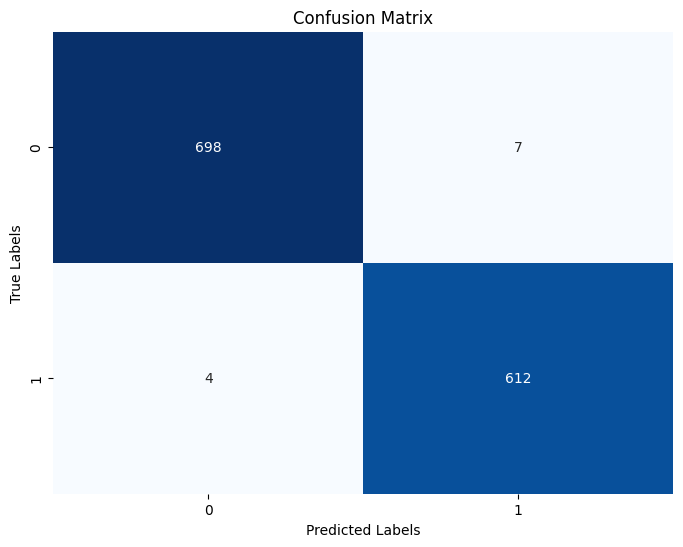

In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'Alexnet_model.pth')

# Save the trained model's state dictionary
model_save_path = '/content/drive/MyDrive/Colab Notebooks/Model/Alexnet_model.pth'
torch.save(model.state_dict(), model_save_path)

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predicted)
print("Confusion Matrix:")
print(cm)

# Compute classification report
class_names = ['Real', 'Fake']
report = classification_report(all_labels, all_predicted, target_names=class_names)
print("Classification Report:")
print(report)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()